In [1]:
import pandas as pd
import scipy
import statsmodels.stats as stats
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import *
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
data = pd.read_csv("/content/_5e732cdeb15894a04f77e5fae011e572_credit_card_default_analysis.csv")

In [ ]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


p == 0.05 везде по дефолту, множественных проверок нет.
Сначала  1) делаем графики, 2) расписываем пару нулевая гипотеза - альтернатива, потом проверяем 3) условия применения определенных критериев, вычисляем 4) значение критерия и потом делаем вывод, сделав 5) замечание относительно практической значимости

# 1 задание

Размер кредитного лимита (LIMIT_BAL)
В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

H0 - медианы равны

H1 - не равны

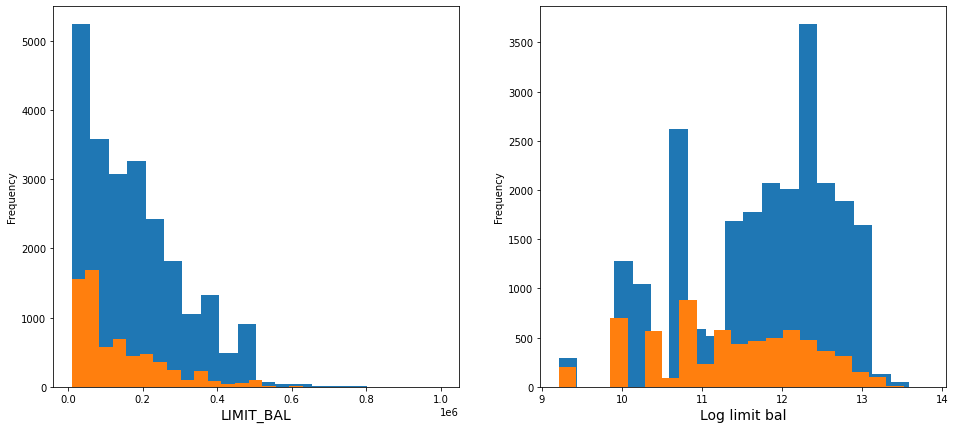

In [12]:
good_clients = data[data['default'] == 0]
bad_clients = data[data['default'] == 1]
plt.figure(figsize(16,7))
plt.subplot(121)
good_clients['LIMIT_BAL'].plot.hist(bins=20)
bad_clients['LIMIT_BAL'].plot.hist(bins=20)
plt.xlabel('LIMIT_BAL', fontsize=14)

plt.subplot(122)
np.log(good_clients['LIMIT_BAL']).plot.hist(bins=20)
np.log(bad_clients['LIMIT_BAL']).plot.hist(bins=20)
plt.xlabel('Log limit bal', fontsize=14)
pylab.show()

видим что и то и другое не слишком похоже на нормальное распределение случайной величины. Ладно, едем проверять гипотезы.

In [6]:
#Первое задание с помощью бутсрэпа
non_defs = data.LIMIT_BAL[data.default == 0]
non_defs_median = non_defs.median()


In [9]:
defs = data.LIMIT_BAL[data.default == 1]
defs_median = defs.median()

In [ ]:
defs_median

90000.0

In [ ]:
non_defs_median

150000.0

In [39]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
print(stat_intervals(list(map(np.median, get_bootstrap_samples(np.array(defs), 1000))), 0.05))
print(stat_intervals(list(map(np.median, get_bootstrap_samples(np.array(non_defs), 1000))), 0.05))

[80000. 90000.]
[150000. 150000.]


Интервалы не пересекаются. Гипотеза о равенстве медианных значений отклоняется - Заёмщики, которые не возвращают кредит, обычно берут меньшую сумму.

С точки зрения практической значимости, неравенство медианных значений означает что банк уже сейчас неплохо справляется с задачей расчёта кредитного лимита LIMIT_BAL, давая меньшие лимиты плохим заёмщикам и бОльшие лимиты хорошим заёмщикам.

1b)
Здесь мы будем проверять нулевую гипотезу о том что распределения LIMIT_BAL одинаковы для плохих и хороших клиентов (сдвиг распределений равен нулю), против двусторонней альтернативы о том что эти значения не равны (сдвиг распределений отличен от нуля) на уровне значимости 95%.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


{'boxes': [<matplotlib.lines.Line2D at 0x7fa1eeff1588>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa1eeff1f98>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa1eeffca58>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fa1eeffc6d8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa1eeff1898>,
  <matplotlib.lines.Line2D at 0x7fa1ef009518>]}

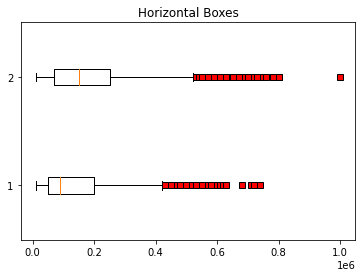

In [ ]:
red_squareragged = dict(markerfacecolor='r', marker='s')
fig5, ax5 = plt.subplots()
ax5.set_title('Horizontal Boxes')
ax5.boxplot([np.array(defs), np.array(non_defs)], vert=False, flierprops=red_squareragged)

Для того, чтобы узнать, использовать ли параметрический или непараметрический критерий, проверим, насколько распределения в выборках отличаются от нормальных.

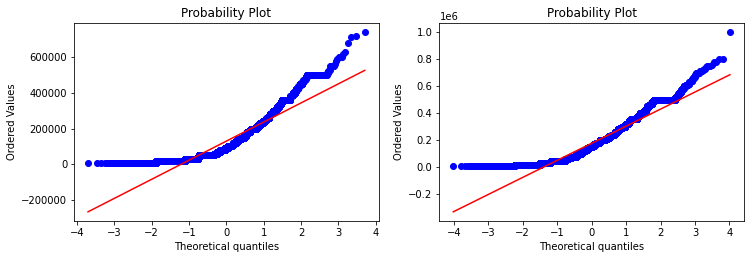

In [ ]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(defs, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(non_defs, dist="norm", plot=pylab)
pylab.show()

In [ ]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(defs))
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(non_defs))

Shapiro-Wilk normality test, W-statistic: 0.854983, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.919726, p-value: 0.000000


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Сильно отличается от нормального распределения. Выбираем непараметрические критерии. Манна-Уитни или перестановочный критерий?

### Ранговый критерий Манна-Уитни и перестановочный критерий

In [ ]:
stats.mannwhitneyu(non_defs, defs)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

In [ ]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

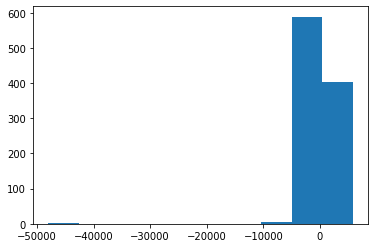

In [ ]:
pylab.hist(permutation_zero_dist_ind(defs, non_defs, max_combinations = 1000))
pylab.show()

In [ ]:
print("p-value: %f" % permutation_test(defs, non_defs ,max_permutations = 10000))

p-value: 0.000100


Видим что нулевая гипотеза о равенстве распределений LIMIT_BAL в двух выборках на уровне значимости 95% отвергается при помощи обоих критериев, а альтернативная гипотеза о неравенстве распределений LIMIT_BAL принимается.

С точки зрения практической значимости, неравенство распределений означает что вероятность невозврата кредита таки зависит от определённого банком для клиента кредитного лимита. Однако конкретную закономерность для этой зависимости описать сложно, и практическая значимость данного вывода несущественна.

# 2 задание

Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.

Нулевая гипотеза: доля мужчин и женщин, не вернувших кредит, одинакова. Двусторонняя альтернатива: доля мужчин и женщин, не вернувших кредит, не одинакова. Гипотезу проверяем на уровне значимости 95%.

Представим решение с помощью доверительного интервала и с помощью Z-критерия для разности долей в независимых выборках. Эти методы подробно разобраны на второй неделе курса

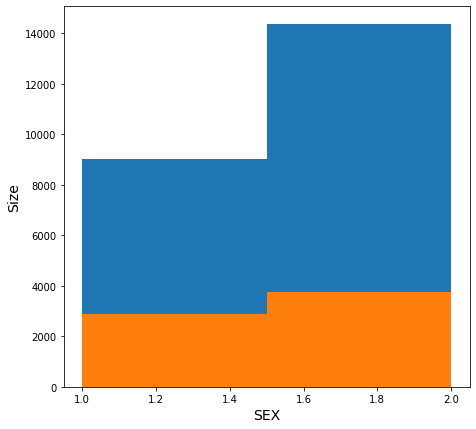

In [13]:
plt.figure(figsize(16,7))
plt.subplot(121)
good_clients['SEX'].plot.hist(bins=2)
bad_clients['SEX'].plot.hist(bins=2)
plt.xlabel('SEX', fontsize=14)
plt.ylabel('Size', fontsize=14)
pylab.show()

Из графика видно что женщины берут кредитов больше чем мужчины. И кажется, более добросовестно кредиты возвращают. Но это надо конечно проверить.

In [24]:
data_male = data.default[data.SEX == 1]
data_female = data.default[data.SEX == 2]

  default | $X_1$ | $X_2$  
  ------------- | -------------| ---------
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [ ]:
from statsmodels.stats.proportion import proportion_confint
normal_interval = proportion_confint(sum(data_male), len(data_male), method = 'wilson')
normal_interval_2 = proportion_confint(sum(data_female), len(data_female), method = 'wilson')

In [ ]:
print('normal_interval [%f, %f] with width %f' % (normal_interval[0],
                                                  normal_interval[1], 
                                                  normal_interval[1] - normal_interval[0]))
print('normal_interval [%f, %f] with width %f' % (normal_interval_2[0],
                                                  normal_interval_2[1], 
                                                  normal_interval_2[1] - normal_interval_2[0]))

normal_interval [0.234061, 0.249450] with width 0.015389
normal_interval [0.201917, 0.213733] with width 0.011816


Интервалы не пересекаются

In [28]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [ ]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(data_male, data_female))

confidence interval: [0.024207, 0.043612]


In [26]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
def proportions_diff_z_test(z_stat, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)
print('p-value: %.15f' % proportions_diff_z_test(proportions_diff_z_stat_ind(np.abs(data_male), np.abs(data_female))))


p-value: 0.000000000004473


Нулевая гипотеза о равенстве долей мужчин и женщин, вернувших кредит, отвергается Z-критерием с p-value 4 * 10e-12. Женщины возвращают кредит на 3% чаще мужчин, доверительный интервал для разности вероятностей [0.024, 0.044] на уровне значимости 95%.

Практическая значимость данного результата - в формуле расчёта кредитного скоринга пол учитывать нужно.

# 3 задание

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?

H0: рассматривая величина имеет равномерное распределение

H1: H0 не верна

In [14]:
non_defs = data[data.default == 0]
defs = data[data.default == 1]


In [15]:
dy = ([len(defs[defs.EDUCATION == 0]), len(non_defs[non_defs.EDUCATION == 0])], 
      [len(defs[defs.EDUCATION == 1]), len(non_defs[non_defs.EDUCATION == 1])], 
      [len(defs[defs.EDUCATION == 2]), len(non_defs[non_defs.EDUCATION == 2])], 
      [len(defs[defs.EDUCATION == 3]), len(non_defs[non_defs.EDUCATION == 3])], 
      [len(defs[defs.EDUCATION == 4]), len(non_defs[non_defs.EDUCATION == 4])], 
      [len(defs[defs.EDUCATION == 5]), len(non_defs[non_defs.EDUCATION == 5])], 
      [len(defs[defs.EDUCATION == 6]), len(non_defs[non_defs.EDUCATION == 6])])

In [16]:
chi, pi_value, ddof, expected = chi2_contingency(dy)

Разность между наблюдаемым и ожидаемым количеством человек

In [17]:
for i in range(7):
  print(*map(int, ((dy[i] - expected[i]))))

-3 3
-305 305
226 -226
149 -149
-20 20
-43 43
-3 3


Разность в процентах - моя модификация исходной таблицы

In [21]:
for i in range(7):
  print(*map(int, ((dy[i] - expected[i])/expected[i])*100))

-100 28
-13 3
7 -2
13 -3
-74 21
-70 20
-29 8


Из таблицы видно, что люди с образованием (0 = доктор, 1 = магистр) практически всегда отдают долги, люди же с  уровнем (2 = бакалавр; 3 = выпускник школы) отдают их реже. Люди с  (4 = начальное образование; 5= прочее; 6 = нет данных) тоже хорошо отдают долги - возможно тут было больше отказов и согласие на кредит давали по другим критериям.

Для того чтобы отвергнуть нулевую гипотезу о том что уровень образования не влияет на вероятность возврата кредита, достаточно проверить её против альтернативы о том что отличия между магистрами и бакалаврами статистически значимы на уровне 95%. Давайте сделаем это, используя те же критерии что и в задании 2:

In [30]:
sample1 = data[data['EDUCATION'] == 1]['default']
sample2 = data[data['EDUCATION'] == 2]['default']
print("95%% confidence interval for a difference between proportions: [%f, %f]" % proportions_confint_diff_ind(sample1, sample2))
print("p-value:", proportions_diff_z_test(proportions_diff_z_stat_ind(sample1, sample2)))

95% confidence interval for a difference between proportions: [-0.055294, -0.034708]
p-value: 0.0


Так и есть. Гипотеза о том что уровень образования не влияет на вероятность возврата кредита отвергается. Уровень образования следует брать во внимание при расчёте задачи кредитного скоринга.

# 4 задание

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

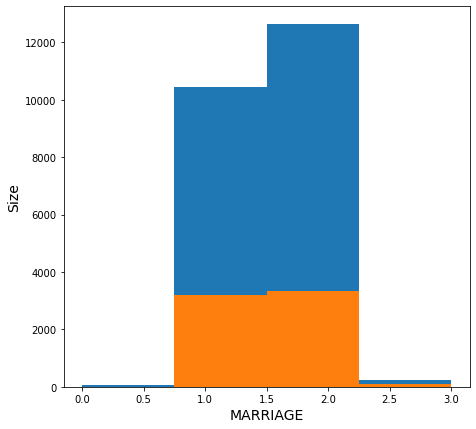

In [31]:
plt.figure(figsize(16,7))
plt.subplot(121)
good_clients['MARRIAGE'].plot.hist(bins=4)
bad_clients['MARRIAGE'].plot.hist(bins=4)
plt.xlabel('MARRIAGE', fontsize=14)
plt.ylabel('Size', fontsize=14)
pylab.show()

Из графика кажется что доля надёжных заёмщиков среди холостых больше чем соответствующая доля среди женатых. Попробуем проверить что это отличие является статистически значимым.

Нулевая гипотеза: доля женатых и холостых, не вернувших кредит, одинакова. Двусторонняя альтернатива: доля женатых и холостых, не вернувших кредит, не одинакова. Используя те же методы что и выше, проверяем гипотезу на уровне значимости 95%.

In [ ]:
dx = ([len(defs[defs.MARRIAGE == 0]), len(non_defs[non_defs.MARRIAGE == 0])], 
      [len(defs[defs.MARRIAGE == 1]), len(non_defs[non_defs.MARRIAGE == 1])], 
      [len(defs[defs.MARRIAGE == 2]), len(non_defs[non_defs.MARRIAGE == 2])], 
      [len(defs[defs.MARRIAGE == 3]), len(non_defs[non_defs.MARRIAGE == 3])])
chi_square, pi, d, expy = chi2_contingency(dx)

In [ ]:
chi_square

35.66239583433609

Критерий Крамера - модификация критерия хи-квадрат, которая отличается нормировкой, этот критерий принадлежит отрезку [0, 1], чем он меньше, тем меньше взаимосвзясь

Статистика критерия Крамера: $$V=\sum_{i=1}^K \frac{\left(n_i- np_i\right)^2}{k-1}$$

In [ ]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [ ]:
print('V Cramer stat value: %.4f' % cramers_stat(np.array(dx)))

V Cramer stat value: 0.0345




Взаимосвязь очень маленькая

In [33]:
sample1 = data[data['MARRIAGE'] == 1]['default']
sample2 = data[data['MARRIAGE'] == 2]['default']
print("95%% confidence interval for a difference between proportions: [%f, %f]" % proportions_confint_diff_ind(sample1, sample2))
print("p-value:", proportions_diff_z_test(proportions_diff_z_stat_ind(sample1, sample2)))

95% confidence interval for a difference between proportions: [0.015929, 0.034938]
p-value: 1.448514344026819e-07


In [35]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_confint_diff_ind(data[data['MARRIAGE'] == 1]['default'], data[data['MARRIAGE'] == 2]['default']))

95% confidence interval for a difference between proportions: [0.015929, 0.034938]


Так и есть. Нулевая гипотеза о равенстве долей женатых и холостых, вернувших кредит, отвергается Z-критерием. Холостые возвращают кредит на 2.5% чаще чем женатые, видимо потому что имея семью кредит вернуть сложнее. Доверительный интервал для разности вероятностей [0.016, 0.034] на уровне значимости 95%.

Практическая значимость данного результата - в формуле расчёта кредитного скоринга семейное положение учитывать нужно, хоть и влияние этого признака очень маленькое.

# 5 задание
Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   a)  о равенстве медианных значений возрастов людей   b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

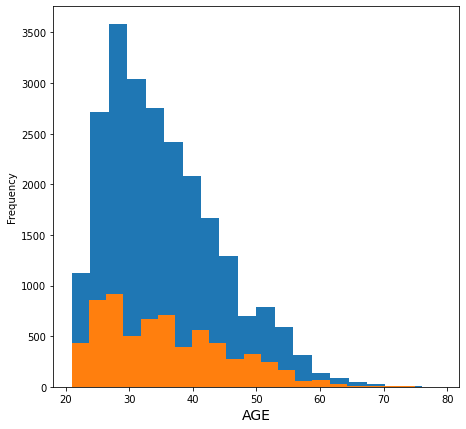

In [36]:
plt.figure(figsize(16,7))
plt.subplot(121)
good_clients['AGE'].plot.hist(bins=20)
bad_clients['AGE'].plot.hist(bins=20)
plt.xlabel('AGE', fontsize=14)
pylab.show()

H0 - медианы равны

H1 - не равны

In [ ]:
print(stat_intervals(list(map(np.median, get_bootstrap_samples(np.array(defs.AGE), 1000))), 0.05))
print(stat_intervals(list(map(np.median, get_bootstrap_samples(np.array(non_defs.AGE), 1000))), 0.05))

[34. 35.]
[34. 34.]


In [40]:
good_clients_median_scores = list(map(np.median, get_bootstrap_samples(good_clients['AGE'].values, 100)))
bad_clients_median_scores = list(map(np.median, get_bootstrap_samples(bad_clients['AGE'].values, 100)))
print("difference between medians:", np.median(good_clients['AGE'].values) - np.median(bad_clients['AGE'].values))

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(good_clients_median_scores, bad_clients_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

difference between medians: 0.0
95% confidence interval for the difference between medians [0. 1.]


Интервалы пересекаются, приближенный способ подтверждает гипотезу о равенстве медиан
С точки зрения практической значимости это означает что возраст можно исключить из списка параметров для расчёта кредитного скоринга.

5b)
Аналогично заданию 1b, здесь мы будем проверять нулевую гипотезу о том что распределения AGE одинаковы для плохих и хороших клиентов (сдвиг распределений равен нулю), против двусторонней альтернативы о том что эти значения не равны (сдвиг распределений отличен от нуля) на уровне значимости 95%.

In [ ]:
print('p-value: %f' % permutation_test(defs.AGE, non_defs.AGE, max_permutations=1000))

p-value: 0.019000


На уровне значимости 95% альтернативная гипотеза отвергается перестановочным критерием. Распределения можно считать равными.

Практическая значимость? Подтверждается то же что и выше: на AGE при расчёте кредитного скоринга можно не смотреть.